In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv")

### Data preparation

In [28]:
df = df[['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']]

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0, inplace=True)

round(df['msrp'].mean())
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)
df.drop('msrp', axis=1, inplace=True)


In [29]:
numerik = [
    'year',
    'engine_hp',
    'engine_cylinders',
    'highway_mpg',
    'city_mpg',
]
kategorik = [
    'make',
    'model',
    'transmission_type',
    'vehicle_style'
]
train_numerik = [
    'year',
    'engine_hp',
    'engine_cylinders',
    'highway_mpg',
    'city_mpg',
]

In [32]:
full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(full_train, test_size=0.25, random_state=1)


df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)


y_train = df_train['above_average'].values
y_test = df_test['above_average'].values
y_val = df_val['above_average'].values


### Question 1

In [33]:
print("Year's ROC AUC score is : ", roc_auc_score(data_train['above_average'], data_train['year']))
print("Engine HP's ROC AUC score is : ", roc_auc_score(data_train['above_average'], data_train['engine_hp']))
print("Engine Cylinder's ROC AUC score is : ", roc_auc_score(data_train['above_average'], data_train['engine_cylinders']))
print("Highway MPG's ROC AUC score is : ", roc_auc_score(data_train['above_average'], data_train['highway_mpg']))
print("City MPG's ROC AUC score is : ", roc_auc_score(data_train['above_average'], data_train['city_mpg']))

Year's ROC AUC score is :  0.687551492804683
Engine HP's ROC AUC score is :  0.9171031265539011
Engine Cylinder's ROC AUC score is :  0.766116490165669
Highway MPG's ROC AUC score is :  0.3669412128227987
City MPG's ROC AUC score is :  0.3265755356754767


### Question 2

In [34]:
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

LogisticRegression(max_iter=1000, solver='liblinear')

In [35]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7148 entries, 0 to 7147
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               7148 non-null   object 
 1   model              7148 non-null   object 
 2   year               7148 non-null   int64  
 3   engine_hp          7148 non-null   float64
 4   engine_cylinders   7148 non-null   float64
 5   transmission_type  7148 non-null   object 
 6   vehicle_style      7148 non-null   object 
 7   highway_mpg        7148 non-null   int64  
 8   city_mpg           7148 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 502.7+ KB


In [38]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [39]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
above_average_decision = (y_pred >= 0.5)
(y_val == above_average_decision).mean()

0.9336970205623164

In [40]:
accuracy_score(y_val, above_average_decision)

0.9336970205623164

### Question 3

In [41]:
scores = []

thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [42]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)


In [43]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,tpr,fpr
0,0.00,654,1729,0,0,0.274444,1.000000,1.000000,1.000000
1,0.01,652,854,2,875,0.432935,0.996942,0.996942,0.493927
2,0.02,651,702,3,1027,0.481153,0.995413,0.995413,0.406015
3,0.03,651,618,3,1111,0.513002,0.995413,0.995413,0.357432
4,0.04,650,559,4,1170,0.537634,0.993884,0.993884,0.323308
...,...,...,...,...,...,...,...,...,...
95,0.95,274,1,380,1728,0.996364,0.418960,0.418960,0.000578
96,0.96,254,1,400,1728,0.996078,0.388379,0.388379,0.000578
97,0.97,241,0,413,1729,1.000000,0.368502,0.368502,0.000000
98,0.98,217,0,437,1729,1.000000,0.331804,0.331804,0.000000


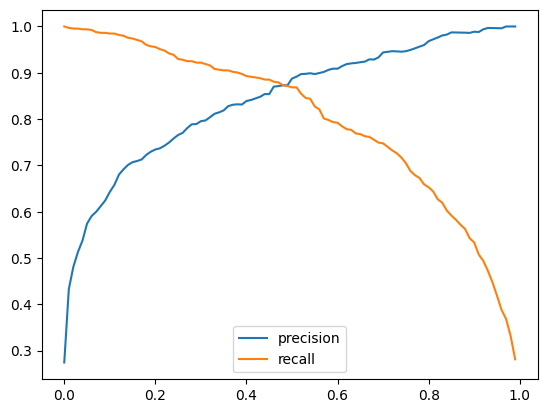

In [44]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4

In [45]:
df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall']/(df_scores['precision'] + df_scores['recall'])

In [46]:
df_scores.loc[df_scores['f1'].idxmax()]

threshold       0.510000
tp            568.000000
fp             69.000000
fn             86.000000
tn           1660.000000
precision       0.891680
recall          0.868502
tpr             0.868502
fpr             0.039907
f1              0.879938
Name: 51, dtype: float64

### Question 5

In [47]:
KFold(n_splits=5, shuffle=True, random_state=1)

KFold(n_splits=5, random_state=1, shuffle=True)

In [48]:
def train(df_train , y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(data, dv, model):
    dicts = data.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train = full_train.iloc[train_idx]
    df_val = full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [50]:
np.mean(scores), np.std(scores)

(0.977840654440015, 0.0004570145749852966)

### Question 6

In [65]:
from tqdm.auto import tqdm
scores = []

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(full_train):
        df_train = full_train.iloc[train_idx]
        df_val = full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append((C, auc))
    
    print('C=%s \t %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))



  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 	 0.481 +- 0.471
C=0.1 	 0.508 +- 0.455
C=0.5 	 0.585 +- 0.411
C=10 	 1.812 +- 3.118


In [53]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.978 +- 0.000


## My answers are:
1) Engine HP
2) 0,97
3) 0,48
4) 0,51
5) 0,003
6) 10